# Fitbit Charge 4: Guide to data extraction and analysis

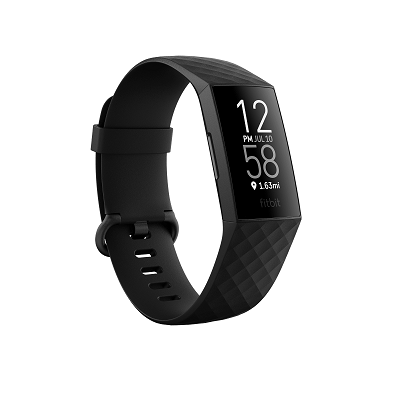

_A picture of the Fitbit Charge 4 that was used for this notebook_

The Fitbit Charge 4 is a **Sleep** and **Physical Activity** tracker consisting of 15 advanced sensors and 16 MB of storage capacity. Read more about the Fitbit Charge 4 [here](https://www.fitbit.com/global/fi/products/trackers/charge4). An updated version, the Fitbit Charge 5, is also available now.

This is a comprehensive, clear guide to extract data from the Fitbit Charge 4 using the Fitbit Web API. Links to external resources and official Fitbit documentation are provided sporadically throughout the guide for further reference.

If you want to know more about the Fitbit, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/fitbit-charge-4) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.
<br></br>
A list of the most important accessible data categories is provided below, For the full list, access the api data in section 3.

Category Name (API version)| Parameter Name (subcategory)| Frequency of Sampling
:-------------------:|:----------------------:|:----------------------:
sleep | date |during the night
sleep | duration |during the night
sleep | efficiency |during the night
sleep | end time |during the night
sleep | sleep levels |during the night
steps | date and time |daily
steps | value (number of steps) |daily
minutesVeryActive | date and time |daily
minutesVeryActive | value | daily
minutesFairlyActive | date and time |daily
minutesFairlyActive | value |daily
minutesLightlyActive | date and time |daily
minutesLightlyActive | value |daily
distance moved | date and time |daily
distance moved | value |daily
minutesSedentary | date and time |daily
minutesSedentary | value |daily
heart rate | resting heart rate |daily (per minute)
heart rate | heart rate zones |daily (per minute)
heart rate | heart rate variability | during sleep (per minute)
temperature | skin temperature | daily
temperature | core temperature | daily
Spo2 | date and time | during sleep
Spo2 | value | during sleep


In this guide, we sequentially cover the following **nine** topics to extract data from the Fitbit API:


1. **Setup**
    - 1.1: Study participant setup and usage
    - 1.2: Library imports
2. **Authentication and Authorization**
3. **Data Extraction**
    - Select the dates
4. **Data Exporting**
    - We export all of this data to file formats
5. **Adherence**
    - We detect when the user isn't using the   device
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced Visualization**
    - 7.1: Visualizing Steps
    - 7.2: Visualizing Sleep Stages
8. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
9. **Statistical Data Analysis**
    - 9.1: Checking for correlation between amount of sedentary activity and total time in bed


*Note: Full documentation of APIs by Fitbit can be found [here](https://dev.fitbit.com/build/reference).

# 1. Setup

## 1.1 Study participant setup and usage


### Participant Setup

Dear Participant,

After creating your Fitbit account, charging the watch and connecting it to your account, download the Fitbit app from the appstore/playstore and start using your Fitbit. You will see that the data is being collected and visualized in the app. Once you have some data, it's easy to access them through the Fitbit Web API if you follow the notebook.

Best,

Wearipedia


### Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Fitbit account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.


To make data available for extraction, you will just need the username and password to generate the API key as illustrated in section 2. Once an API key is generated, these would be no need for the log-in information on the researcher's side.

#1.2 Library imports

In [ ]:
import wearipedia

import base64
import hashlib
import html
import json
import os
import re
import urllib.parse
import requests
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.covariance import EllipticEnvelope
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter
import numpy as np

# 2. Authentication and Authorization

To obtain access to the data using the Web API, authentication and authorization is required. Fitbit supports the OAuth 2.0 protocol, with three different models (read more about it [here](https://dev.fitbit.com/build/reference/web-api/authorization/)).

Briefly, Fitbit offers three workflows for their Web APIs in order of lowest level of security to the highest:
* Implicit Grant Flow
* Authorization Code Grant Flow
* Authorization Code Grant Flow with PKCE
<br></br>

We will discuss two authenication/authorization methods, namely the **Implicit Grant Flow** and the **Authorization Code Grant Flow with PKCE**.

The full documentation for all workflows are provided [here](https://dev.fitbit.com/build/reference/web-api/developer-guide/authorization/).

## 2.1 Implicit Grant Flow

## 2.2 Authorization Code Grant Flow

### 2.2.1 Registering an application

First, register an application on [here](https://dev.fitbit.com/apps/new) while logged in. OAuth 2.0 Application Type should be set to **Client** or **Personal** and the Callback URL is the address through which you can receive your token (https://127.0.0.1/, also known as the [localhost](https://en.wikipedia.org/wiki/Localhost), is provided as an example, but any link accessible locally should suffice; [8080](https://www.quora.com/What-is-port-8080-used-for#:~:text=Port%208080%20is%20typically%20used%20for%20a%20personally%20hosted%20web%20server) is the port). Other sections can be filled without particular specifications (e.g. https://google.com for all website links). An image with the important sections highlight are provided below for clarity.

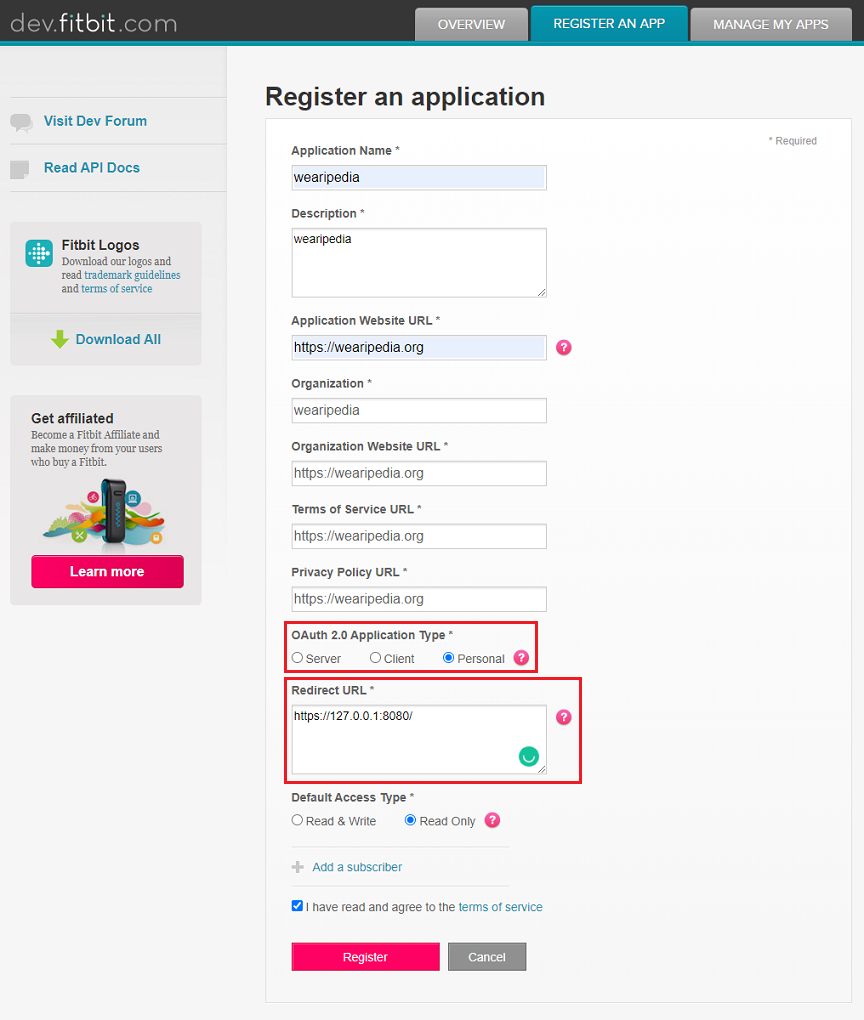

The `client_id` and `client_secret` can be accessed under **Manage My Apps**.

An image is provided below for clarity.

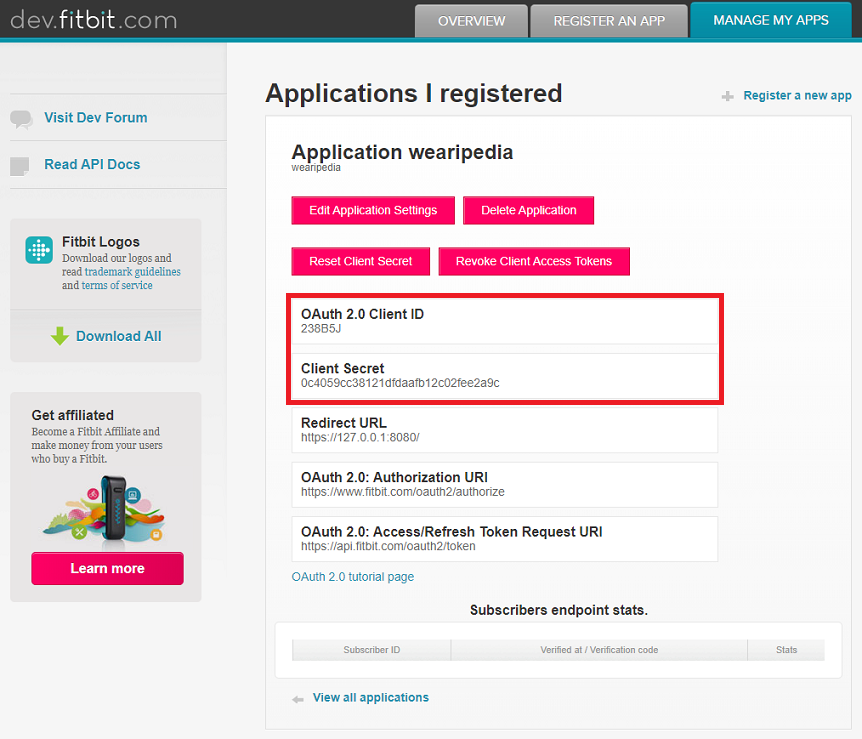

The wearipedia API will walk you through interactively getting an access token with your client ID and secret if you enter an empty access token (recommended for first-time users). After receiving an access token, you can pass it in directly to authenticate without going through the interactive steps in the future.


In [ ]:
access_token = "" #@param {type:"string"}
synthetic = False #@param {type:"boolean"}

device = wearipedia.get_device("fitbit/fitbit_charge_4")

if not synthetic:
  device.authenticate(access_token)

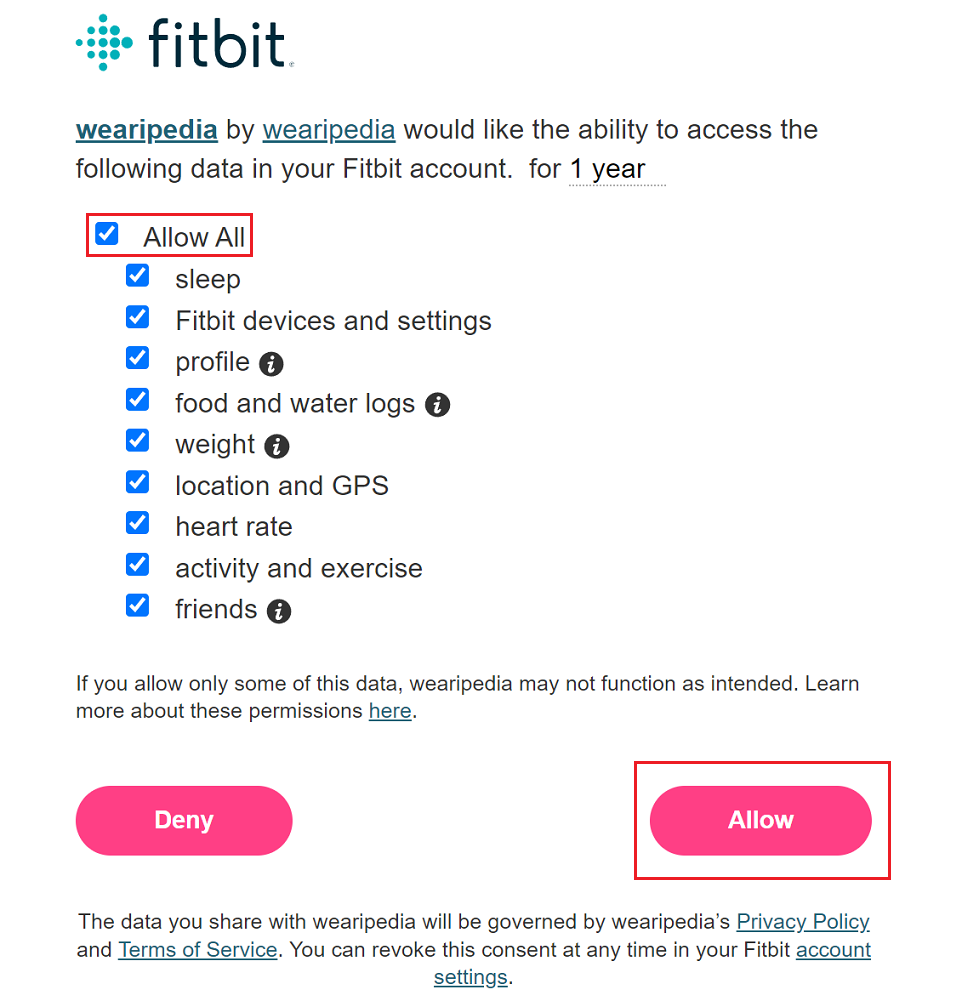

### 2.2.3 Calling the API

If you'd like to call the API endpoints directly, you can authorize with an header as shown below.

In [ ]:
# executes a GET request on the API
def call_API(
    access_token: str,
    url: str,
    call: str = "GET"
):
    headers = {
        "Authorization": "Bearer " + access_token
    }
    return requests.request(
        call, url=url, headers=headers).json()

In [ ]:
# calls user profile
call_API(
    access_token=access_token,
    url="https://api.fitbit.com/1/user/-/profile.json"
)#["user"].keys()

### 2.2.4 Refresh Tokens

Tokens have a specified TTL (time to live) determined earlier by the `expires` parameter. Once that time is over, a new token must be issued.

# 3. Data Extraction

Here we are going to use the Wearipedia API to handle the Oauth connection. A full list of data types and endpoints are available [here](https://dev.fitbit.com/build/reference/web-api/explore/).

In brief, the categories are:
* [Activity](https://dev.fitbit.com/build/reference/web-api/activity/)
* [Activity Intraday Time Series](https://dev.fitbit.com/build/reference/web-api/activity/#get-activity-intraday-time-series)
* [Activity Time Series](https://dev.fitbit.com/build/reference/web-api/activity/#get-activity-intraday-time-series)
* [Body and Weight](https://dev.fitbit.com/build/reference/web-api/body/)
* [Body and Weight Time Series](https://dev.fitbit.com/build/reference/web-api/body/#body-time-series)
* [Devices](https://dev.fitbit.com/build/reference/web-api/devices/)
* [Food and Water](https://dev.fitbit.com/build/reference/web-api/nutrition/)
* [Food and Water Time Series](https://dev.fitbit.com/build/reference/web-api/nutrition/)
* [Friends](https://dev.fitbit.com/build/reference/web-api/friends/)
* [Heart Rate Intraday Time Series](https://dev.fitbit.com/build/reference/web-api/heartrate-timeseries/)
* [Heart Rate Time Series](https://dev.fitbit.com/build/reference/web-api/heartrate-timeseries/)
* [Sleep](https://dev.fitbit.com/build/reference/web-api/sleep/)
* [Subscriptions](https://dev.fitbit.com/build/reference/web-api/subscription/)
* [User](https://dev.fitbit.com/build/reference/web-api/user/)

Authorization is a post only endpoint as demonstrated in previous sections (used to obtain access token).
* **POST-ONLY**: [Auth](https://dev.fitbit.com/build/reference/web-api/developer-guide/authorization/)

In [ ]:
#@title Set up the start and end dates (YYYY-MM-DD)
START_DATE = "2022-12-11" #@param {type:"string"}
END_DATE = "2022-12-17" #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

# Parameters for retrieving data from the device
params = {"seed": 100, "start_date": START_DATE, "end_date": END_DATE}


# Retrieve data for the data categories
sleep = device.get_data("sleep", params)
steps = device.get_data("steps", params)
minutesVeryActive = device.get_data("minutesVeryActive", params)
minutesFairlyActive = device.get_data("minutesFairlyActive", params)
minutesLightlyActive = device.get_data("minutesLightlyActive", params)
distance = device.get_data("distance", params)
minutesSedentary = device.get_data("minutesSedentary", params)

# Store the retrieved data in a dictionary
api_data = {}
api_data['sleep'] = sleep
api_data['steps'] = steps
api_data['minutesVeryActive'] = minutesVeryActive
api_data['minutesFairlyActive'] = minutesFairlyActive
api_data['minutesLightlyActive'] = minutesLightlyActive
api_data['distance'] = distance
api_data['minutesSedentary'] = minutesSedentary

In [ ]:
api_data

# 4. Data Exporting

## Exporting to JSON (R, Matlab, etc.), CSV, and Excell.

In this section, we export all of this data to JSON, which  with popular scientific computing software (R, Matlab).
Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [ ]:
import json


#@title Select which format to export data!
# set which format you prefer to export
use_JSON = True #@param {type:"boolean"}
use_CSV = True #@param {type:"boolean"}
use_Excel = True #@param {type:"boolean"}

if use_JSON:

  json.dump(api_data["sleep"], open("sleep.json", "w"))
  json.dump(api_data["steps"], open("steps.json", "w"))
  json.dump(api_data["minutesVeryActive"], open("minutesVeryActive.json", "w"))
  json.dump(api_data["minutesFairlyActive"], open("minutesFairlyActive.json", "w"))
  json.dump(api_data["minutesLightlyActive"], open("minutesLightlyActive.json", "w"))
  json.dump(api_data["distance"], open("distance.json", "w"))
  json.dump(api_data["minutesSedentary"], open("minutesSedentary.json", "w"))

  complete = {
      "sleep": api_data["sleep"],
      "steps": api_data["steps"],
      "minutesVeryActive": api_data["minutesVeryActive"],
      "minutesFairlyActive": api_data["minutesFairlyActive"],
      "minutesLightlyActive": api_data["minutesLightlyActive"],
      "distance": api_data["distance"],
      "minutesSedentary": api_data["minutesSedentary"],

  }

  json.dump(complete, open("complete.json", "w"))

if use_CSV:
  pd.DataFrame(api_data["sleep"]).to_csv("sleep.csv", index=False)
  pd.DataFrame(api_data["steps"]).to_csv("steps.csv", index=False)
  pd.DataFrame(api_data["minutesVeryActive"]).to_csv("minutesVeryActive.csv", index=False)
  pd.DataFrame(api_data["minutesFairlyActive"]).to_csv("minutesFairlyActive.csv", index=False)
  pd.DataFrame(api_data["minutesLightlyActive"]).to_csv("minutesLightlyActive.csv", index=False)
  pd.DataFrame(api_data["distance"]).to_csv("distance.csv", index=False)
  pd.DataFrame(api_data["minutesSedentary"]).to_csv("minutesSedentary.csv", index=False)

if use_Excel:
  pd.DataFrame(api_data["sleep"]).to_excel("sleep.xlsx", index=False)
  pd.DataFrame(api_data["steps"]).to_excel("steps.xlsx", index=False)
  pd.DataFrame(api_data["minutesVeryActive"]).to_excel("minutesVeryActive.xlsx", index=False)
  pd.DataFrame(api_data["minutesFairlyActive"]).to_excel("minutesFairlyActive.xlsx", index=False)
  pd.DataFrame(api_data["minutesLightlyActive"]).to_excel("minutesLightlyActive.xlsx", index=False)
  pd.DataFrame(api_data["distance"]).to_excel("distance.xlsx", index=False)
  pd.DataFrame(api_data["minutesSedentary"]).to_csv("minutesSedentary.csv", index=False)


# 5. Data Adherence

In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level). We will first delete chunks of data, given user input, and then visualize user non-adherence.

In [ ]:
#@title 5.1 Non-adherence simulation and detection
import random as random

# First prep the data for removing data points
api_data['sleep'] = api_data['sleep'][0]["sleep"]
api_data['steps'] = api_data['steps'][0]["activities-steps"]
api_data['minutesVeryActive'] = api_data['minutesVeryActive'][0]["activities-minutesVeryActive"]
api_data['minutesFairlyActive'] = api_data['minutesFairlyActive'][0]["activities-minutesFairlyActive"]
api_data['minutesLightlyActive'] = api_data['minutesLightlyActive'][0]["activities-minutesLightlyActive"]
api_data['distance'] = api_data['distance'][0]["activities-distance"]
api_data['minutesSedentary'] = api_data['minutesSedentary'][0]["activities-minutesSedentary"]



block_level = "day" #@param ["day", "week"]
steps_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
sleep_nonadherence_percent = 0.03 #@param {type:"slider", min:0, max:1, step:0.01}
minutesVeryActive_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
minutesFairlyActive_nonadherence_percent = 0.09 #@param {type:"slider", min:0, max:1, step:0.01}
distance_nonadherence_percent = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
minutesLightlyActive_nonadherence_percent = 0.09 #@param {type:"slider", min:0, max:1, step:0.01}
minutesSedentary_nonadherence_percent = 0.04 #@param {type:"slider", min:0, max:1, step:0.01}

detect_adherence_only = False #@param {type:"boolean"}


def remove_entries(data, percent):
    """
    Removes a percentage of entries from a list of lists.

    :param data: list of lists representing the entries to be processed
    :param percent: float representing the percentage of entries to be removed
    :return: list of lists representing the remaining entries after removal
    """
    num_entries = len(data)
    num_entries_to_keep = int(percent * num_entries)
    idxes_to_keep = np.random.choice(np.arange(num_entries), replace=False, size=num_entries_to_keep)
    return [data[i] for i in idxes_to_keep]

sleep_adherence = remove_entries(api_data['sleep'], sleep_nonadherence_percent)
steps_adherence = remove_entries(api_data['steps'], steps_nonadherence_percent)
minutesVeryActive_adherence = remove_entries(api_data['minutesVeryActive'], minutesVeryActive_nonadherence_percent)
distance_adherence = remove_entries(api_data['distance'], distance_nonadherence_percent)
minutesFairlyActive_adherence = remove_entries(api_data['minutesFairlyActive'], minutesFairlyActive_nonadherence_percent)
minutesLightlyActive_adherence = remove_entries(api_data['minutesLightlyActive'], minutesLightlyActive_nonadherence_percent)
minutesSedentary_adherence = remove_entries(api_data['minutesSedentary'], minutesSedentary_nonadherence_percent)

if not detect_adherence_only:
    if block_level == "day":
        block_length = 1
    elif block_level == "week":
        block_length = 7

    sleep_num_blocks_to_keep = int((1 - sleep_nonadherence_percent) * len(api_data['sleep']))
    steps_num_blocks_to_keep = int((1 - steps_nonadherence_percent) * len(api_data['sleep']))
    minutesVeryActive_num_blocks_to_keep = int((1 - minutesVeryActive_nonadherence_percent) * len(api_data['sleep']))
    minutesFairlyActive_num_blocks_to_keep = int((1 - minutesFairlyActive_nonadherence_percent) * len(api_data['sleep']))
    distance_num_blocks_to_keep = int((1 - distance_nonadherence_percent) * len(api_data['sleep']))
    minutesLightlyActive_num_blocks_to_keep = int((1 - minutesLightlyActive_nonadherence_percent) * len(api_data['sleep']))
    minutesSedentary_num_blocks_to_keep = int((1 - minutesSedentary_nonadherence_percent) * len(api_data['sleep']))

    minutesVeryActive_idxes = np.random.choice(np.arange(len(api_data['minutesVeryActive'])), replace=False, size=minutesVeryActive_num_blocks_to_keep)
    minutesVeryActive_adherence = [api_data['minutesVeryActive'][i] for i in minutesVeryActive_idxes]
    api_data['minutesVeryActive'] = minutesVeryActive_adherence

    sleep_idxes = np.random.choice(np.arange(len(api_data['sleep'])), replace=False, size=sleep_num_blocks_to_keep)
    sleep_adherence = [api_data['sleep'][i] for i in sleep_idxes]
    api_data['sleep'] = sleep_adherence

    steps_idxes = np.random.choice(np.arange(len(api_data['steps'])), replace=False, size=steps_num_blocks_to_keep)
    steps_adherence = [api_data['steps'][i] for i in steps_idxes]
    api_data['steps'] = steps_adherence

    minutesFairlyActive_idxes = np.random.choice(np.arange(len(api_data['minutesFairlyActive'])), replace=False, size=minutesFairlyActive_num_blocks_to_keep)
    minutesFairlyActive_adherence = [api_data['minutesFairlyActive'][i] for i in minutesFairlyActive_idxes]
    api_data['minutesFairlyActive'] = minutesFairlyActive_adherence

    distance_idxes = np.random.choice(np.arange(len(api_data['distance'])), replace=False, size=distance_num_blocks_to_keep)
    distance_adherence = [api_data['distance'][i] for i in distance_idxes]
    api_data['distance'] = distance_adherence

    minutesLightlyActive_idxes = np.random.choice(np.arange(len(api_data['minutesLightlyActive'])), replace=False, size=minutesLightlyActive_num_blocks_to_keep)
    minutesLightlyActive_adherence = [api_data['minutesLightlyActive'][i] for i in minutesLightlyActive_idxes]
    api_data['minutesLightlyActive'] = minutesLightlyActive_adherence

    minutesSedentary_idxes = np.random.choice(np.arange(len(api_data['minutesSedentary'])), replace=False, size=minutesSedentary_num_blocks_to_keep)
    minutesSedentary_adherence = [api_data['minutesSedentary'][i] for i in minutesSedentary_idxes]
    api_data['minutesSedentary'] = minutesSedentary_adherence

# After the alteration of the data, lets return it to the original form
api_data['sleep'] = [ {"sleep": api_data['sleep']} ]
api_data['steps'] = [ {"activities-steps": api_data['steps']} ]
api_data['minutesVeryActive'] = [ {"activities-minutesVeryActive": api_data['minutesVeryActive']} ]
api_data['minutesFairlyActive'] = [ {"activities-minutesFairlyActive": api_data['minutesFairlyActive']} ]
api_data['minutesLightlyActive'] = [ {"activities-minutesLightlyActive": api_data['minutesLightlyActive']} ]
api_data['distance'] = [ {"activities-distance": api_data['distance']} ]
api_data['minutesSedentary'] = [ {"activities-minutesSedentary": api_data['minutesSedentary']} ]



### 5.2 Non-adherence visualization


Here we are going to look into what days data wasn't collected. Since the days in which data wasn't collected show "zero" values for the data, then filter this out to increase the accuracy of the analysis. This is because zero values will be consided data points in the analysis which will alter the results.

In [ ]:
# First we are going to aggregate the data in arrays. We are taking distance as an example here
dates = []
distances = []

print(api_data['minutesVeryActive'][0])
for datapoint in api_data['distance'][0]['activities-distance']:
    dates.append(datapoint['dateTime'])
    distances.append(float(datapoint['value']))

#Using a pandas dataframe to aggregate the data
d = {'Distance (km)': distances, 'Date': dates}
df = pd.DataFrame(data=d)

#Creating the plot
sns.set_theme(style="dark")
ax = sns.barplot(x="Distance (km)", y="Date", data=df, palette = 'Dark2_r' )


From the graph you can see the day(s) which have the distance as zero. These are the non-wear days and now we are creating a simple function to filter them out.

In [ ]:
#since the data will consist of multiple arrays carrying multiple data points,
# we will create the function such that it gets the list of arrays as a parameter
# and the refrence index for the array to examine the data from

def remove_non_wear(lst, refrence_index):
  newlst = []
  for i in range(len(lst)):
    newlst.append([])

  for index in range(len(lst[refrence_index])):
    if lst[refrence_index][index] != 0:
      for array in lst:
        newlst[lst.index(array)].append(array[index])
  return newlst


In [ ]:
#Now let's test this
new_arrays = remove_non_wear([dates, distances], 1)

#creating a new plot with the new data
dates = new_arrays[0]
distances = new_arrays[1]

#Using a pandas dataframe to aggregate the data
d = {'Distance (km)': distances, 'Date': dates}
df = pd.DataFrame(data=d)

#Creating the plot
sns.set_theme(style="dark")
ax = sns.barplot(x="Distance (km)", y="Date", data=df, palette = 'Dark2')

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

In [ ]:
feature = "steps" #@param ["minutesVeryActive", "distance", "steps"]
smoothness = 0.25 #@param {type:"slider", min:0, max:1, step:0.01}
sigma = 10 * smoothness

if feature == "steps":
  steps = []
  dates = []
  for datapoint in api_data['steps'][0]['activities-steps']:
      dates.append(str(datapoint['dateTime']))
      steps.append(float(datapoint['value']))

  steps = list(gaussian_filter(steps, sigma=sigma))

  d = {'Date': dates, 'steps': steps}
  df = pd.DataFrame(data=d)

  with plt.style.context('tableau-colorblind10'):
      #Creating the plot
      #Resizing the plot
      fig,ax = plt.subplots()
      fig.set_size_inches(12,10)

      sns.set_theme(style="dark")
      ax = sns.lineplot(x="Date", y="steps", data=df, color = 'g'  )

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # rotates and right-aligns the x labels so they don't crowd each other.
      for label in ax.get_xticklabels(which='major'):
          label.set(rotation=90, horizontalalignment='right')

      plt.show()

elif feature == "distance":

  distance = []
  dates = []
  for datapoint in api_data['distance'][0]['activities-distance']:
      dates.append(str(datapoint['dateTime']))
      distance.append(float(datapoint['value']))

  distance = list(gaussian_filter(distance, sigma=sigma))

  d = {'Date': dates, 'distance': distance}
  df = pd.DataFrame(data=d)

  with plt.style.context('tableau-colorblind10'):
      #Creating the plot
      #Resizing the plot
      fig,ax = plt.subplots()
      fig.set_size_inches(12,10)

      sns.set_theme(style="dark")
      ax = sns.lineplot(x="Date", y="distance", data=df, color = 'r'  )

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # rotates and right-aligns the x labels so they don't crowd each other.
      for label in ax.get_xticklabels(which='major'):
          label.set(rotation=90, horizontalalignment='right')

      plt.show()

elif feature == "minutesVeryActive":

  minutesVeryActive = []
  dates = []
  for datapoint in api_data['minutesVeryActive'][0]['activities-minutesVeryActive']:
      dates.append(str(datapoint['dateTime']))
      minutesVeryActive.append(float(datapoint['value']))

  minutesVeryActive = list(gaussian_filter(minutesVeryActive, sigma=sigma))

  d = {'Date': dates, 'minutesVeryActive': minutesVeryActive}
  df = pd.DataFrame(data=d)

  with plt.style.context('tableau-colorblind10'):
      #Creating the plot
      #Resizing the plot
      fig,ax = plt.subplots()
      fig.set_size_inches(12,10)

      sns.set_theme(style="dark")
      ax = sns.lineplot(x="Date", y="minutesVeryActive", data=df, color = 'b'  )

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # rotates and right-aligns the x labels so they don't crowd each other.
      for label in ax.get_xticklabels(which='major'):
          label.set(rotation=90, horizontalalignment='right')

      plt.show()



# 7. Advanced Visualization

## 7.1 Visualizing Steps

Here we are going to try replicating this plot from the fitbit app. First, we gather the data in arrays, select the data for the desired days then we create a bar plot. Afterwards, we format the bar graph to like the original graph and place the labels.

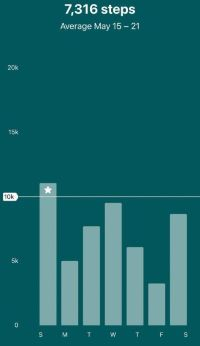

In [ ]:
try:
  # First gather the data in arrays
  dates = []
  steps = []
  for datapoint in api_data['steps'][0]['activities-steps']:
      dates.append(datapoint['dateTime'])
      steps.append(float(datapoint['value']))

  # We need only 7 days' worth of data so we slice the arrays
  dates = dates[0:7]
  steps = steps[0:7]

  with plt.style.context('dark_background'):
      #Creating the plot
      fig,ax = plt.subplots()
      fig.set_size_inches(3,5.5)
      plt.bar(dates, steps, color = '#80a9ab', edgecolor = '#80a9ab')

      fig.patch.set_facecolor('#02575c')
      plt.gca().set_facecolor('#02575c')

      #Adjusting the labels
      thesteps = [0, 5000, 10000, 15000, 20000]
      plt.yticks(ticks=thesteps, labels=['0', '5k', '10k','15k', '20k'])
      plt.xticks(ticks=dates, labels=['S', 'M', 'T','W','T', 'F', 'S'])

      # removing the borders from four sides
      plt.gca().spines['left'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      #adding labels
      average_steps = sum(steps) / len(steps)
      plt.figtext(0.5,1.0, str(int(average_steps))[0] + ',' + str(int(average_steps))[1:4] + " steps", fontsize=14, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.5,0.96, 'Average December 11 - 17', fontsize=10, ha='center', color ='w', fontweight = 'light')

      # Creating a horizontal line at 10k steps
      plt.axhline(y=10000, linewidth = 0.5)
except:
  print("this plot depends on the entire week's data existence. Fix the steps' adherence to show the plot")


Now, it looks very similar to the original Plot!

## 7.2 Visualizing Sleep Stages

Here we are trying to replicate the sleep stages visual from the fitbit app. It's very similar to the previous plot but with some extra edits, and adding the legend. Like the previous one, we are collecting 7 days' sleep data and plotting them in a bar graph.

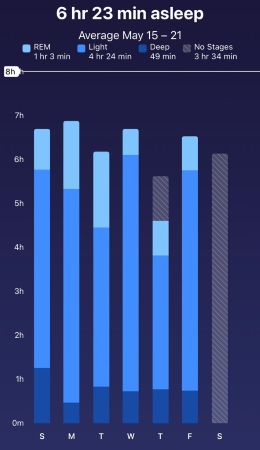

In [ ]:
# first we collect the data in arrays

try:

  asleep = []
  dates_sleep = []
  light = []
  rem = []
  deep = []
  no_stages = []

  for datapoint in api_data['sleep'][0]['sleep']:
        asleep.append(float(datapoint['minutesAsleep']))
        dates_sleep.append(datapoint['dateOfSleep'])
        if "rem" in datapoint['levels']['summary']:
          rem.append(float(datapoint['levels']['summary']['rem']['minutes']))
        else:
          rem.append(0)
        if "light" in datapoint['levels']['summary']:
          light.append(float(datapoint['levels']['summary']['light']['minutes']))
        else:
          light.append(0)
        if "deep" in datapoint['levels']['summary']:
          deep.append(float(datapoint['levels']['summary']['deep']['minutes']))
        else:
          deep.append(0)
  #fill the no_stages data
  for i in range(len(asleep)):
      no_stages.append(asleep[i]-(rem[i]+deep[i]+light[i]))

  #get the ordered dates from the steps data
  dates = []
  for datapoint in api_data['steps'][0]['activities-steps']:
      dates.append(datapoint['dateTime'])
  dates = dates[0:7]


  #adjust the order of the dates and take the needed 7 days
  # also we are adding major and minor sleep values which appear as different
  #entries with the same date

  light_new = [0]*len(dates)
  rem_new = [0]*len(dates)
  deep_new = [0]*len(dates)
  no_stages_new = [0]*len(dates)
  asleep_new = [0]*len(dates)

  for i,entry in enumerate(dates):
      for j, date in enumerate(dates_sleep):
        if date == entry:
            light_new[i] += light[j]
            rem_new[i] += rem[j]
            deep_new[i]+= deep[j]
            no_stages_new[i] += no_stages[j]
            asleep_new[i] += asleep[j]

  #Now plot the graph
  colors = ['#81c4f9', '#418cff', '#184ba5', '#505071']

  bottom1 = []
  for i in range(len(deep_new)):
    bottom1.append(deep_new[i]+light_new[i])

  bottom2 = []
  for i in range(len(deep_new)):
    bottom2.append(rem_new[i]+bottom1[i])

  with plt.style.context('dark_background'):

      #adjust size
      fig,ax = plt.subplots()
      fig.set_size_inches(4,7)


      plt.bar(dates, deep_new, color=colors[2], edgecolor = colors[2], width = 0.5)
      plt.bar(dates, light_new, bottom = deep_new, color=colors[1], edgecolor = colors[1], width = 0.5)
      plt.bar(dates, rem_new, bottom = bottom1, color=colors[0], edgecolor = colors[0], width = 0.5)
      plt.bar(dates, no_stages_new, bottom = bottom2, color=colors[3], edgecolor = colors[3], width = 0.5)


      #adjust colors
      fig.patch.set_facecolor('#22204e')
      plt.gca().set_facecolor('#22204e')

      #Adjusting the labels
      thesteps = [0, 60, 2*60, 3*60, 4*60, 5*60, 6*60, 7*60, 8*60]
      plt.yticks(ticks=thesteps, labels=['0m', '1h', '2h','3h', '4h', '5h', '6h', '7h', '8h'])
      plt.xticks(ticks=dates, labels=['S', 'M', 'T','W','T', 'F', 'S'])

      # removing the borders from four sides
      plt.gca().spines['left'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # Creating a horizontal line at 8h steps
      plt.axhline(y=8*60, linewidth = 0.5)

      #add labels
      average_sleep_time = sum(asleep_new) / len(asleep_new)
      hours = int((average_sleep_time//60))
      mins = int(int(average_sleep_time) - hours*60)
      plt.figtext(0.5,1.0, str(hours) + ' hr ' + str(mins) + " mins asleep", fontsize=15, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.5,0.96, 'Average May 15 - 21', fontsize=10, ha='center', color ='w', fontweight = 'light')


      # set legend below plot
      plt.legend(["", "REM", "Light","Deep","No Stages"], loc='upper center', bbox_to_anchor=(0.4, 1.1),
                  fancybox=True, shadow=True, ncol=5, fontsize= 8, frameon=False, handlelength=0.9)
      #set legen colors
      ax = plt.gca()
      leg = ax.get_legend()
      leg.legendHandles[0].set_color('#22204e')
      leg.legendHandles[1].set_color('#81c4f9')
      leg.legendHandles[2].set_color('#418cff')
      leg.legendHandles[3].set_color('#184ba5')
      leg.legendHandles[4].set_color('#505071')

      #adding legend labels
      length_rem = len(rem_new) - rem_new.count(0)
      length_deep = len(deep_new) - deep_new.count(0)
      length_light = len(light_new) - light_new.count(0)
      length_nostages = len(no_stages_new) - no_stages_new.count(0)

      hours_rem = int((sum(rem_new)/length_rem) // 60)
      hours_deep = int(sum(deep_new)/length_deep //60)
      hours_light = int(sum(light_new)/length_light //60)
      hours_nostages = int(sum(no_stages_new)/(length_nostages+0.001) //60)

      mins_rem = int((sum(rem_new)/length_rem) - hours_rem*60)
      mins_deep = int(sum(deep_new)/length_deep - hours_deep*60)
      mins_light = int(sum(light_new)/length_light - hours_light*60)
      mins_nostages = int(sum(no_stages_new)/(length_nostages+0.001) - hours_nostages*60)

      plt.figtext(0.25,0.9, str(hours_rem) + ' hr ' + str(mins_rem) + " min", fontsize=7.5, ha='center', color ='w', fontweight = 'light')
      plt.figtext(0.42,0.9, str(hours_light) + ' hr ' + str(mins_light) + " min", fontsize=7.5, ha='center', color ='w', fontweight = 'light')
      plt.figtext(0.59,0.9, str(hours_deep) + ' hr ' + str(mins_deep) + " min", fontsize=7.5, ha='center', color ='w', fontweight = 'light')
      plt.figtext(0.76,0.9, str(hours_nostages) + ' hr ' + str(mins_nostages) + " min", fontsize=7.5, ha='center', color ='w', fontweight = 'light')

except:
  print("this plot depends on the entire week's data existence. Fix the sleep adherence to show the plot")


Now this looks very similar to the original graph!

# 8. Outlier Detection and Data Cleaning

We find outliers and remove them in order to get better analysis accuracy by removing the possibility of measurement errors, but at the same time it can affect the result's accuracy since some outliers are true outliers: outliers that is important in the data itelf. Check [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7485938) out to learn more about the effects of removing outliers.

Here we are going to find abnormalities in the data using the Elliptic Envelope algorithm, which is a machine learning algorith that creates a hypothetical ellipse around the set of data and points outside of this envelope are considered outliers. Check [this](https://towardsdatascience.com/machine-learning-for-anomaly-detection-elliptic-envelope-2c90528df0a6) to learn more about the algorithm.

We can implement this algorithm by utilizing sklearn library which has the built in Elliptic Envelope function.

In [ ]:
#creating a function that detects outliers
def find_outliers(arr):
  list_of_outliers = []
  # Create a dataframe
  d = {'arr': arr}
  df = pd.DataFrame(data=d)

  # here we return the a list where the indexies with -1 values are where the
  # outliers are at. learn more about the implementation here:
  # https://www.datatechnotes.com/2020/04/anomaly-detection-with-elliptical-envelope-in-python.html
  pred = EllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,
                 store_precision=True, support_fraction=None).fit_predict(df['arr'].array.reshape(-1, 1))
  for i in range(len(pred)):
    if pred[i] == -1:
      list_of_outliers.append(arr[i])
  return list_of_outliers

Now lets put this to test

In [ ]:
#Here we are going to take the steps as an example
#First aggregate the needed data in arrays.

dates = []
steps = []
for datapoint in api_data['steps'][0]['activities-steps']:
    dates.append(datapoint['dateTime'])
    steps.append(float(datapoint['value']))

# After this lets filter out the non-wear days
new_arrays = remove_non_wear([dates, steps], 1)
dates = new_arrays[0]
steps = new_arrays[1]

#inject an outlier value
steps[-1] = 2


outliers = find_outliers(steps)
print(outliers)

So this worked! Now lets try to plot the outliers!

In [ ]:
#creting a list of dates that correspond to the outlier values in sleep
outlier_dates = []
for i in range(len(steps)):
    if steps[i] in outliers:
        outlier_dates.append(dates[i])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot without highlighting outliers
sns.scatterplot(x=steps, y=dates, ax=axes[0], color='g')
axes[0].set_xlabel('steps')
axes[0].set_ylabel('dates')
axes[0].set_title('Plot without Outliers')

# Plot with highlighting outliers
sns.scatterplot(x=steps, y=dates, ax=axes[1], color='g')
sns.scatterplot(x=outliers, y=outlier_dates, ax=axes[1], color='r')
axes[1].set_xlabel('steps')
axes[1].set_ylabel('dates')
axes[1].set_title('Plot with Outliers')

plt.tight_layout()
plt.show(block=True)


The outlier now appears in a different color!

# 9. Statistical Data Analysis

## 9.1 Checking for Correlation Between Amount Of Sedentary Activity and The Time In Bed

Research Question: Is there a correlation between sedentary activity (very low intensity activity) and the time spent in bed?

**Null Hypothesis ($H_0$)**: There is no correlation between sedentary activity and time in bed. Any observed correlation is due to random chance.

**Alternative Hypothesis ($H_A$)**: There is a correlation between sedentary activity and time in bed. The correlation could be positive, indicating that as sedentary activity increases, time in bed also increases, or negative, indicating that as sedentary activity increases, time in bed decreases.

**Methodology** To test this, we will use Pearson's correlation coefficient. It helps measure any potential link, be it positive or negative and how strong this link is.

In [ ]:
#First aggregate the data in arrays
dates_activity = []
minutes = []
sleep = []
dates_sleep = []
for datapoint in api_data['minutesSedentary'][0]['activities-minutesSedentary']:
    dates.append(datapoint['dateTime'])
    minutes.append(float(datapoint['value']))
for datapoint in api_data['sleep'][0]['sleep']:
    try:
      sleep.append(float(datapoint['timeInBed'])/60)
      dates_sleep.append(datapoint['dateOfSleep'])
    except:
      continue

# then filter the data from non-wear days
new_arrays = remove_non_wear([dates, minutes], 1)
dates_activity = new_arrays[0]
minutes = new_arrays[1]

#now adjust the arrays so that the dates match.
dates_activity_new = []
minutes_new = []
sleep_new = []

for i in dates_activity:
  if i in dates_sleep:
    dates_activity_new.append(i)
    minutes_new.append(minutes[dates_activity.index(i)])
    sleep_new.append(sleep[dates_sleep.index(i)])

# create a dataframex
d = {'Very Low Activity (mins)': minutes_new, 'Time in bed (Hours)': sleep_new}
df = pd.DataFrame(data=d)

#plot the data
graph = sns.lmplot(data=df, y="Very Low Activity (mins)", x="Time in bed (Hours)")
plt.show(block=True)


Now lets test the null hypothesis that amount of time in bed does not increase as the Sedantary activity amount increases. Looks like there is indeed a trend here, but an aggressive critic might argue that it could result from chance. To provide strong quantitative evidence in favor of our claim, which is that the null hypothesis is indeed false, we perform the Wald test, which addresses this setting precisely.


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(sleep_new,minutes_new)
print(p_value)

As we can see, the p-value, or the probability that assuming the slope is zero that we have obtained a slope of at least this magnitude, is small <\.05, we fail to reject the null hypothesis. This means that there is not enough evidence to conclude that there is a significant correlation between sedentary activity and time spent in bed.

## 9.2 Checking for Correlation Between the number of steps and distance covered in a day

Research Question: Is there a correlation between the distance covered and the number of steps taken?

**Null Hypothesis ($H_0$)**: There is no correlation between the distance covered and the number of steps taken. Any observed correlation is due to random chance.

**Alternate Hypothesis ($H_1$)**: There is a correlation between the distance covered and the number of steps taken. The correlation could be positive, indicating that as the number of steps increases, the distance covered also increases, or negative, indicating that as the number of steps increases, the distance covered decreases.

Methodology To test this, we will use Pearson's correlation coefficient. It helps measure any potential link, be it positive or negative, and how strong this link is.

In [ ]:
#First aggregate the data in arrays
dates_steps = []
steps = []
distance = []
dates_distance = []

for datapoint in api_data['steps'][0]['activities-steps']:
    dates_steps.append(datapoint['dateTime'])
    steps.append(float(datapoint['value']))

for datapoint in api_data['distance'][0]['activities-distance']:
    if datapoint['dateTime'] in dates_steps:
      distance.append(float(datapoint['value']))
      dates_distance.append(datapoint['dateTime'])

for ele in dates_steps:
  if ele not in dates_distance:
    inx = dates_steps.index(ele)
    steps.pop(inx)
    dates_steps.pop(inx)


# create a dataframex
d = {'Distance moved (Km)' : distance, 'Number of steps': steps}
df = pd.DataFrame(data=d)

#plot the data
graph = sns.lmplot(data=df, y="Distance moved (Km)", x="Number of steps")
plt.show(block=True)


Now lets test the null hypothesis that the number of steps measured per day does not increase as the distance covered. Looks like there is indeed a trend here, but lets be precise.

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(distance,steps)
print(p_value)

The p-value suggests that there is no statistically significant correlation between the variables being studied. This means that any observed correlation between distance covered and number of steps taken, is likely due to random chance. In other words, there is not enough evidence to reject the null hypothesis, which states that there is no correlation between the variables.